# Inference tests

In [1]:
!hostname
!python -c "import jax; print(jax.default_backend(), jax.devices())"
# !nvidia-smi
# numpyro.set_platform("gpu")

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.33' # NOTE: jax preallocates GPU (default 75%)

import matplotlib.pyplot as plt
import numpy as np

import jax
import jax.numpy as jnp
from jax import random, jit, vmap, grad

import numpyro
import numpyro.distributions as dist
from numpyro.handlers import seed, condition, trace

%matplotlib inline
%load_ext autoreload 
%autoreload 2

feynmangpu04.cluster.local
gpu [cuda(id=0)]


## Toy model

Out of any model, build mixture sampler and mixture logprob.

In [2]:
init_key = random.PRNGKey(0)
dim = 2
radius = 3
loc = radius * jnp.ones(dim) / dim**0.5
mode1 = dist.MultivariateNormal(loc=loc, covariance_matrix=jnp.eye(dim))
mode2 = dist.MultivariateNormal(loc= -loc, covariance_matrix=jnp.eye(dim))
cat = dist.Categorical(jnp.array([.75, .25]))
mixture = dist.MixtureGeneral(cat, [mode1, mode2])

mixture_samples = mixture.sample(init_key, (1000,))
lw = mixture.log_prob(mixture_samples)

2023-12-19 14:51:39.889594: W external/xla/xla/service/gpu/nvptx_compiler.cc:679] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


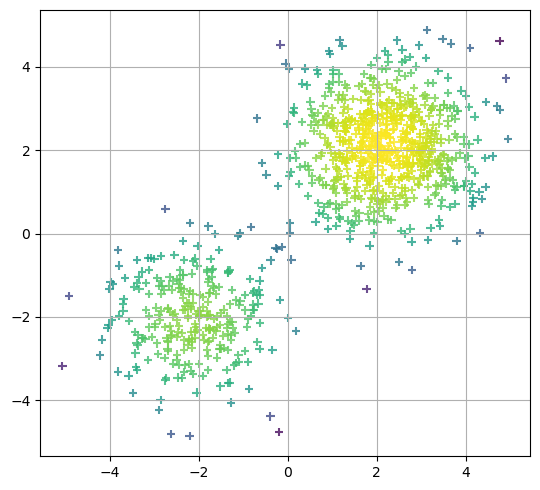

In [3]:
plt.figure(figsize=(5.5,5))
plt.scatter(*mixture_samples[:, :2].T, c=lw, marker='+', alpha=.8)
plt.grid()
plt.tight_layout()
plt.show();

Now same but in a numpyro model.

In [4]:
def mixture_model(dim=2, 
                  radius=3,
                  sigma=0,):
    loc = radius * jnp.ones(dim) / dim**0.5 # same euclidiean distance between modes for any dim
    # loc = jnp.zeros(dim)
    # loc = loc.at[0].set(radius)
    mode1 = dist.MultivariateNormal(loc=loc, covariance_matrix=jnp.eye(dim)*(1+sigma**2))
    mode2 = dist.MultivariateNormal(loc= -loc, covariance_matrix=jnp.eye(dim)*(1+sigma**2))
    cat = dist.Categorical(jnp.array([.75, .25]))
    mixture = dist.MixtureGeneral(cat, [mode1, mode2])
    mixt =  numpyro.sample('mixt', mixture)
    # TODO: maybe rather a normal prior, then move according to categorical
    return mixt

sample_fn = vmap(lambda rng_key, model_kwargs: seed(mixture_model, rng_key)(**model_kwargs), in_axes=(0, None))

from numpyro.infer.util import log_density
logp_fn = lambda mixt_val, sigma, model_kwargs: log_density(model=mixture_model, 
                                                            model_args=(), 
                                                            model_kwargs=model_kwargs, 
                                                            params={'mixt':mixt_val})[0]/(1+sigma**2)
score_fn = grad(logp_fn, argnums=0)
logp_vfn = vmap(logp_fn, in_axes=(0, None, None))
score_vfn = vmap(score_fn, in_axes=(0, None, None))
# logp_fn(jnp.array([[1],[2]]),sigma=0,model_kwargs={}),\
# logp_fn(jnp.array([[1,1],[2,2]]),sigma=0,model_kwargs={}),\
# logp_fn(jnp.array([1]),sigma=0,model_kwargs={}) + logp_fn(jnp.array([2]),sigma=0,model_kwargs={})

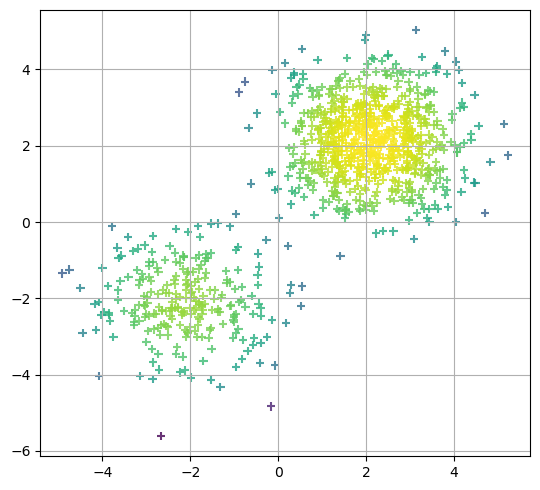

In [5]:
model_kwargs = {'dim':2, 'radius':3}
n_samples = 1000
samples = sample_fn(random.split(init_key, n_samples), model_kwargs)
sigma = 0
logps = logp_vfn(samples, sigma, model_kwargs)
scores = score_vfn(samples, sigma, model_kwargs)

plt.figure(figsize=(5.5,5))
plt.scatter(*samples[:, :2].T, c=logps, marker='+', alpha=.8)
plt.grid()
plt.tight_layout()
plt.show();

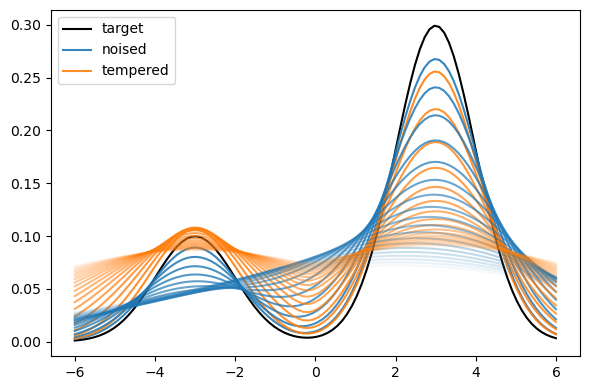

In [6]:
model_kwargs = {'dim':1, 'radius':3, 'sigma':0}
border = 2*model_kwargs['radius']
xs = jnp.linspace(-border,border,100)
sigmas = jnp.linspace(0.5,5,20)
p_vfn = lambda x, sigma, model_kwargs: jnp.exp(logp_vfn(x, sigma, model_kwargs))

plt.figure(figsize=(6,4))
plt.plot(xs, p_vfn(xs, 0, model_kwargs), 'k', label='target')

for i_sigma, sigma in enumerate(sigmas):
    # noised
    model_kwargs['sigma'] = sigma
    plt.plot(xs, p_vfn(xs, 0, model_kwargs), 'C0', alpha=float(1-sigma/max(sigmas)), label="noised")
    # tempered
    model_kwargs['sigma'] = 0
    pdf_temp = p_vfn(xs, sigma, model_kwargs)
    pdf_temp = pdf_temp / (2* border * pdf_temp.mean())
    plt.plot(xs, pdf_temp, 'C1', alpha=float(1-sigma/max(sigmas)), label="tempered")
    if i_sigma==0:
        plt.legend()
plt.tight_layout()
plt.show();

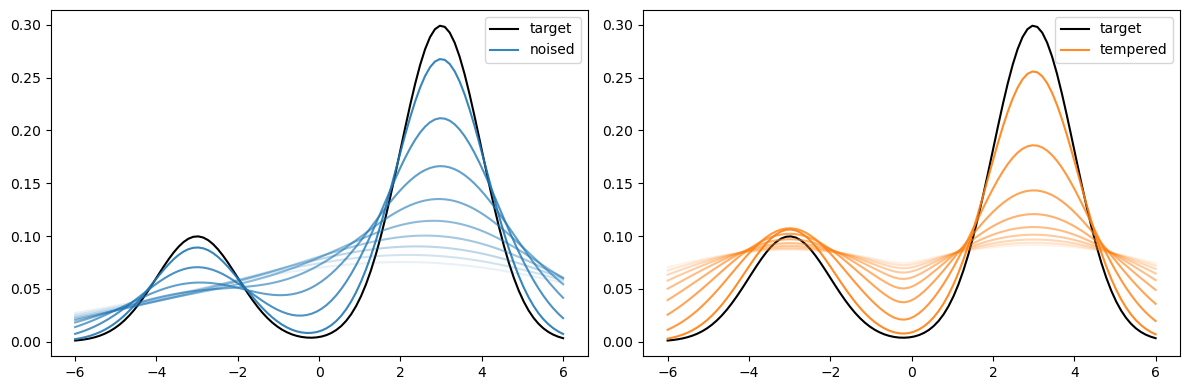

In [7]:
from scipy.integrate import simps # XXX
model_kwargs = {'dim':1, 'radius':3, 'sigma':0}
border = 2*model_kwargs['radius']
xs = jnp.linspace(-border,border,100)
sigmas = jnp.linspace(0.5,5,10)
p_vfn = lambda x, sigma, model_kwargs: jnp.exp(logp_vfn(x, sigma, model_kwargs))

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(xs, p_vfn(xs, 0, model_kwargs), 'k', label='target')
for i_sigma, sigma in enumerate(sigmas):
    # noised
    model_kwargs['sigma'] = sigma
    plt.plot(xs, p_vfn(xs, 0, model_kwargs), 'C0', alpha=float(1-sigma/max(sigmas)), label="noised")
    if i_sigma==0:
        plt.legend()

plt.subplot(122)
model_kwargs['sigma'] = 0
plt.plot(xs, p_vfn(xs, 0, model_kwargs), 'k', label='target')
for i_sigma, sigma in enumerate(sigmas):
    # tempered
    model_kwargs['sigma'] = 0
    pdf_temp = p_vfn(xs, sigma, model_kwargs)
    pdf_temp = pdf_temp / (2* border * pdf_temp.mean())
    plt.plot(xs, pdf_temp, 'C1', alpha=float(1-sigma/max(sigmas)), label="tempered")
    if i_sigma==0:
        plt.legend()

plt.tight_layout()
plt.show();

## Sampling from SDE

In [28]:
from diffrax import diffeqsolve, ControlTerm, Euler, MultiTerm, ODETerm, SaveAt, VirtualBrownianTree, ReversibleHeun
t0, t1 = 5., 0.
model_kwargs = {'dim':1, 'radius':2, 'sigma':0}
drift = lambda t, y, args: - 0.5 * score_fn(y, t/t0, model_kwargs) # Now sigma is a function of time
diffusion = lambda t, y, args: jnp.ones_like(y)
solver = Euler()
saveat = SaveAt(ts=jnp.linspace(t0,t1))

@jax.jit
@jax.vmap
def get_samples(y, seed):
  brownian_motion = VirtualBrownianTree(t0, t1, tol=1e-4, shape=(), key=seed)
  terms = MultiTerm(ODETerm(drift), ControlTerm(diffusion, brownian_motion))
  return diffeqsolve(terms, solver, t0, t1, dt0=-0.001, y0=y, max_steps=10_000, saveat=saveat).ys

In [29]:
model_kwargs = {'dim':1, 'radius':3, 'sigma':0}
n_samples = 100_000
init_samples = sample_fn(random.split(init_key, n_samples), model_kwargs)

res = get_samples(init_samples, random.split(random.PRNGKey(8), n_samples))

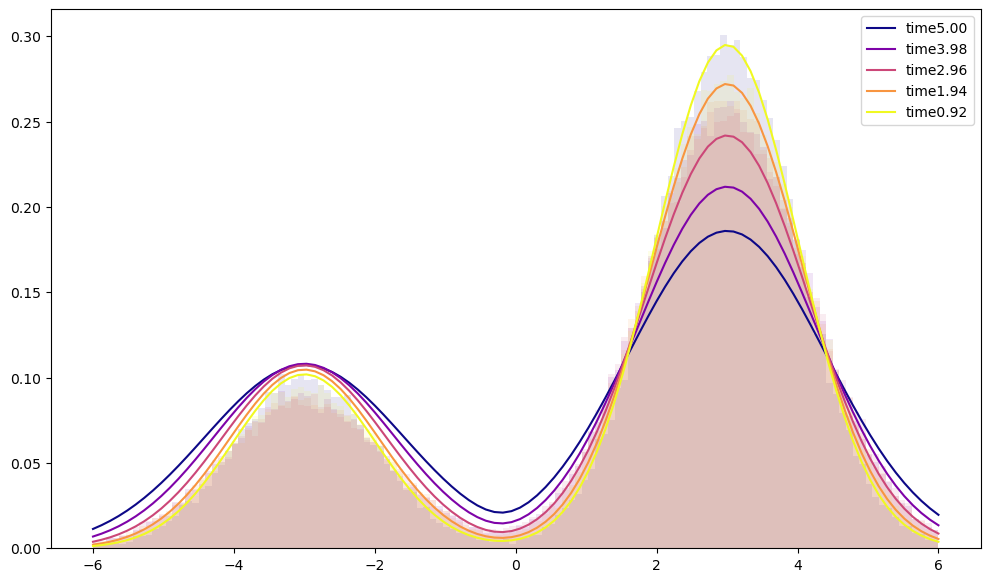

In [31]:
# T=5
colors = plt.cm.plasma(np.linspace(0,1,5))
border = 2*model_kwargs['radius']
xs = jnp.linspace(-border,border,100)

plt.figure(figsize=[12,7])
for i,t in enumerate(saveat.subs.ts[::10]):
  # posterior = make_likelihood(t/t0).prob(x**2)*make_prior(t/t0).prob(x)
  model_kwargs['sigma'] = 0
  pdf_temp = p_vfn(xs, t/t0, model_kwargs)
  pdf_temp = pdf_temp / (2* border * pdf_temp.mean())
  plt.plot(xs, pdf_temp, color=colors[i], label=f"time{t:.2f}")
  plt.hist(res[:,i*10,0],128,range=[-border,border], density=True,alpha=0.1,color=colors[i]);
plt.legend();